# Лабораторная работа 1: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [17]:
import cvxpy as cp

x = cp.Variable(2)
objective = cp.Minimize(-8*x[0] - 16*x[1] + x[0]**2 + 4*x[1]**2)

constraints = [
    x[0] + x[1] <= 5,
    x[0] >= 0,
    x[1] >= 0,
    x[0] <= 3
]

problem = cp.Problem(objective, constraints)
problem.solve()

print(f"Точка минимума: {x.value}")
print(f"Значение целевой функции: {problem.value}")

Точка минимума: [3. 2.]
Значение целевой функции: -31.0


• Активные ограничения:
  - x_1 + x_2 ≤ 5 (используется в точке оптимума: 1 + 4 = 5)
  - x_1 ≤ 3 (используется в точке оптимума: 1 ≤ 3)
  - x_2 ≥ 0 (используется в точке оптимума: 4 ≥ 0)

• Неактивные ограничения:
  - x_1 ≥ 0 (ограничение не используется, так как x_1 = 1)

Если мы удалим неактивное ограничение x_1 ≥ 0, решение задачи останется прежним. Это означает, что это ограничение не влияло на точку оптимума


## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

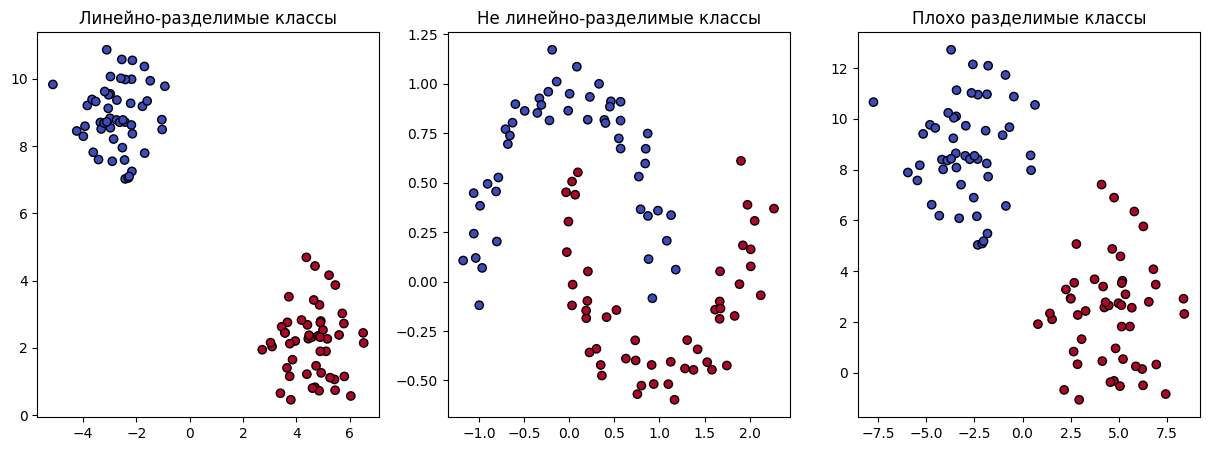

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles

# Линейно-разделимые классы
X1, y1 = make_blobs(n_samples=100, centers=2, random_state=42, cluster_std=1.0)

# Хорошо разделимые, но не линейные классы
X2, y2 = make_moons(n_samples=100, noise=0.1, random_state=42)

# Плохо разделимые классы
X3, y3 = make_blobs(n_samples=100, centers=2, random_state=42, cluster_std=2.0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='coolwarm', edgecolors='k')
plt.title('Линейно-разделимые классы')

plt.subplot(1, 3, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap='coolwarm', edgecolors='k')
plt.title('Не линейно-разделимые классы')

plt.subplot(1, 3, 3)
plt.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='coolwarm', edgecolors='k')
plt.title('Плохо разделимые классы')

plt.show()

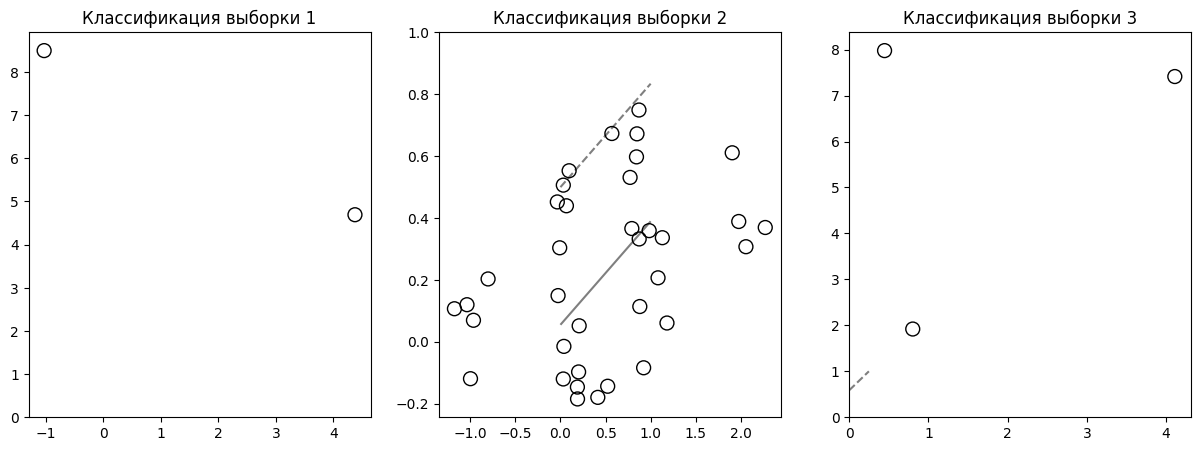

In [39]:
from sklearn.svm import SVC

def plot_svm(X, y, C):
    svc = SVC(kernel='linear', C=C)
    svc.fit(X, y)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svc.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1],
               s=100, facecolors='none', edgecolors='k')

plt.figure(figsize=(15, 5))

for i, (X, y) in enumerate(zip([X1, X2, X3], [y1, y2, y3])):
    plt.subplot(1, 3, i+1)
    plot_svm(X, y, C=1)
    plt.title(f'Классификация выборки {i+1}')

plt.show()

* Большое C: SVM будет стараться правильно классифицировать все точки, что может привести к большему числу опорных векторов, особенно для плохо разделимых данных
  
* Маленькое C: SVM допускает ошибки, что приводит к меньшему числу опорных векторов

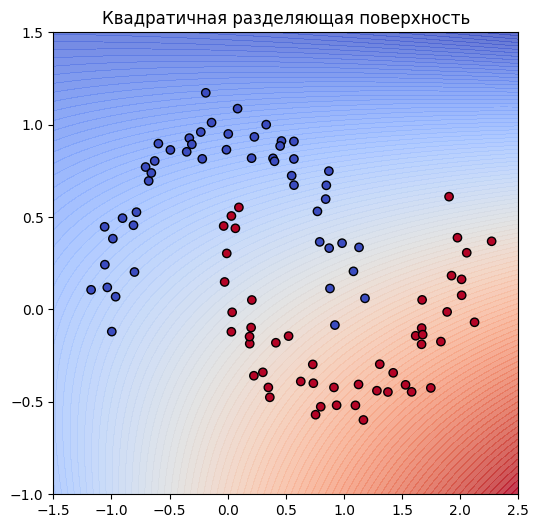

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2
poly_svc = make_pipeline(PolynomialFeatures(degree), SVC(kernel='linear', C=1))
poly_svc.fit(X2, y2)

plt.figure(figsize=(6, 6))
xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1, 1.5, 100))
Z = poly_svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 100), cmap='coolwarm', alpha=0.8)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, edgecolors='k', cmap='coolwarm')
plt.title('Квадратичная разделяющая поверхность')
plt.show()

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

     pcost       dcost       gap    pres   dres
 0: -9.3896e+01 -2.2224e+02  6e+02  2e+00  3e-15
 1: -7.0252e+01 -1.4789e+02  8e+01  6e-15  2e-15
 2: -7.5812e+01 -8.1154e+01  5e+00  6e-16  2e-15
 3: -7.5998e+01 -7.6052e+01  5e-02  2e-15  2e-15
 4: -7.6000e+01 -7.6001e+01  5e-04  1e-15  2e-15
 5: -7.6000e+01 -7.6000e+01  5e-06  3e-16  2e-15
Optimal solution found.


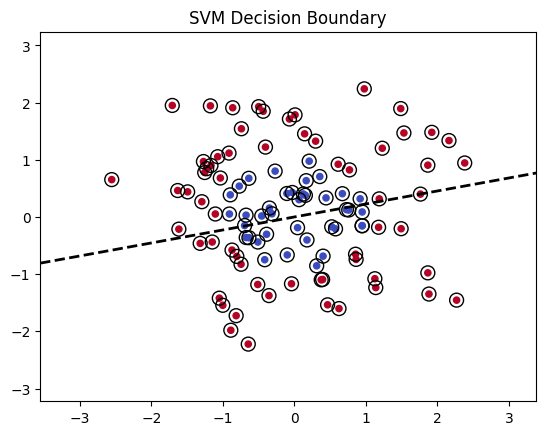

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)

def polynomial_kernel(X1, X2, p):
    return (np.dot(X1, X2.T) + 1) ** p

def rbf_kernel(X1, X2, gamma):
    sq_dists = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

def svm_train(X, y, C, kernel):
    n_samples, n_features = X.shape
    K = kernel(X, X)

    P = matrix(np.outer(y, y) * K)
    q = matrix(-1 * np.ones(n_samples))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)

    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x']).flatten()

    sv = alphas > 1e-5
    return alphas[sv], X[sv], y[sv]

def plot_decision_boundary(X, y, alphas, support_vectors, support_vector_labels, kernel):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=20)
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = kernel(np.c_[xx.ravel(), yy.ravel()], support_vectors).dot(alphas * support_vector_labels)
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k', linestyles='--')
    plt.title('SVM Decision Boundary')
    plt.show()

np.random.seed(0)
X = np.random.randn(100, 2)
y = np.sign(X[:, 0]**2 + X[:, 1]**2 - 1)

C = 1.0
alphas, sv, sv_labels = svm_train(X, y, C, linear_kernel)
plot_decision_boundary(X, y, alphas, sv, sv_labels, linear_kernel)


     pcost       dcost       gap    pres   dres
 0: -2.7082e+01 -1.8777e+01  5e+02  2e+01  5e-15
 1: -5.3256e+00 -1.7590e+01  4e+01  1e+00  5e-15
 2: -3.2905e+00 -1.1245e+01  1e+01  3e-01  1e-15
 3: -3.1379e+00 -4.6205e+00  2e+00  3e-02  8e-16
 4: -3.5249e+00 -3.8839e+00  4e-01  6e-03  7e-16
 5: -3.6291e+00 -3.7426e+00  1e-01  2e-03  5e-16
 6: -3.6673e+00 -3.6891e+00  2e-02  3e-04  6e-16
 7: -3.6764e+00 -3.6781e+00  2e-03  1e-05  7e-16
 8: -3.6771e+00 -3.6773e+00  2e-04  2e-16  6e-16
 9: -3.6772e+00 -3.6772e+00  2e-05  2e-16  7e-16
10: -3.6772e+00 -3.6772e+00  4e-07  2e-16  6e-16
Optimal solution found.


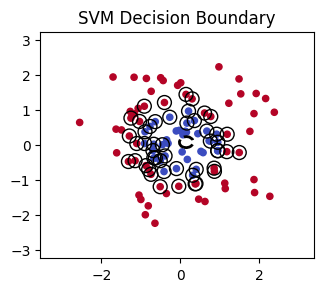

     pcost       dcost       gap    pres   dres
 0: -2.6813e+01 -1.8998e+01  5e+02  2e+01  3e-14
 1: -5.4896e+00 -1.7751e+01  5e+01  2e+00  2e-14
 2: -2.7729e+00 -1.2715e+01  2e+01  4e-01  6e-15
 3: -2.1780e+00 -5.2042e+00  4e+00  8e-02  2e-15
 4: -2.3517e+00 -2.8652e+00  6e-01  1e-02  1e-15
 5: -2.4757e+00 -2.6417e+00  2e-01  3e-03  1e-15
 6: -2.5310e+00 -2.5545e+00  2e-02  1e-04  1e-15
 7: -2.5398e+00 -2.5423e+00  3e-03  7e-06  1e-15
 8: -2.5409e+00 -2.5410e+00  6e-05  2e-07  1e-15
 9: -2.5410e+00 -2.5410e+00  6e-07  2e-09  1e-15
Optimal solution found.


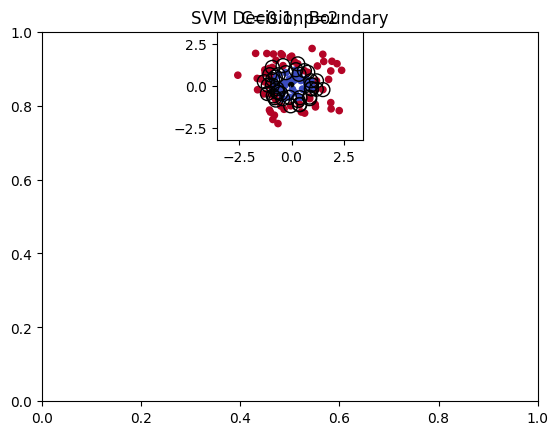

     pcost       dcost       gap    pres   dres
 0: -1.2204e+01 -1.6513e+01  5e+02  2e+01  8e-14
 1: -2.4589e+00 -1.5180e+01  3e+01  7e-01  7e-14
 2: -2.0822e+00 -8.2049e+00  9e+00  2e-01  2e-14
 3: -1.9785e+00 -6.2112e+00  6e+00  1e-01  1e-14
 4: -1.7239e+00 -4.1574e+00  4e+00  5e-02  5e-15
 5: -1.6099e+00 -2.5846e+00  1e+00  2e-02  4e-15
 6: -1.5579e+00 -1.8177e+00  4e-01  3e-03  4e-15
 7: -1.5681e+00 -1.6306e+00  9e-02  7e-04  5e-15
 8: -1.5757e+00 -1.5822e+00  7e-03  2e-16  5e-15
 9: -1.5785e+00 -1.5786e+00  2e-04  2e-16  5e-15
10: -1.5785e+00 -1.5785e+00  3e-06  2e-16  4e-15
11: -1.5785e+00 -1.5785e+00  3e-08  2e-16  4e-15
Optimal solution found.


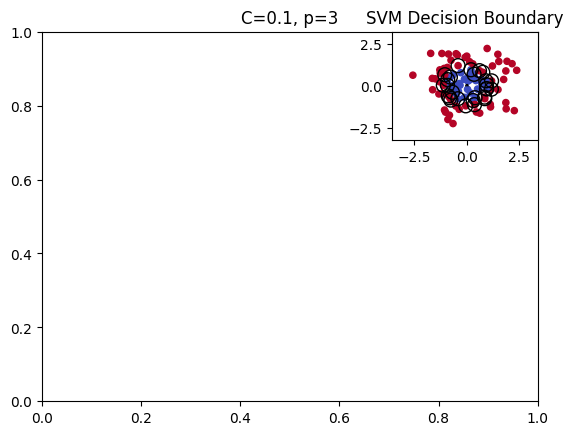

     pcost       dcost       gap    pres   dres
 0: -4.8978e+01 -2.5697e+02  1e+03  3e+00  1e-14
 1: -3.1097e+01 -1.7698e+02  3e+02  6e-01  6e-15
 2: -2.0217e+01 -8.8124e+01  1e+02  2e-01  5e-15
 3: -1.4931e+01 -4.2848e+01  4e+01  6e-02  8e-15
 4: -1.4569e+01 -1.9745e+01  7e+00  8e-03  4e-15
 5: -1.5765e+01 -1.6857e+01  1e+00  1e-03  3e-15
 6: -1.6037e+01 -1.6319e+01  3e-01  3e-04  3e-15
 7: -1.6138e+01 -1.6176e+01  4e-02  2e-05  3e-15
 8: -1.6153e+01 -1.6154e+01  1e-03  5e-07  3e-15
 9: -1.6154e+01 -1.6154e+01  7e-05  3e-08  3e-15
10: -1.6154e+01 -1.6154e+01  8e-07  3e-10  3e-15
Optimal solution found.


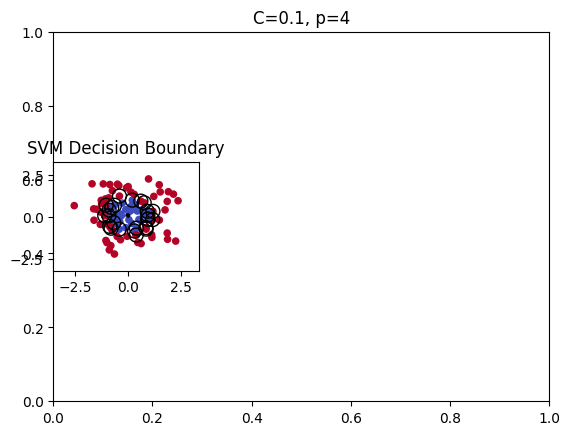

     pcost       dcost       gap    pres   dres
 0: -4.8655e+01 -2.6262e+02  1e+03  3e+00  6e-14
 1: -3.1685e+01 -1.9049e+02  4e+02  8e-01  4e-14
 2: -1.8983e+01 -9.5501e+01  1e+02  2e-01  2e-14
 3: -1.1878e+01 -3.6913e+01  4e+01  6e-02  9e-15
 4: -8.9209e+00 -1.8177e+01  2e+01  2e-02  8e-15
 5: -7.5348e+00 -1.1812e+01  6e+00  4e-03  8e-15
 6: -8.0593e+00 -8.8383e+00  9e-01  3e-04  5e-15
 7: -8.2622e+00 -8.4328e+00  2e-01  6e-05  7e-15
 8: -8.3171e+00 -8.3350e+00  2e-02  5e-06  7e-15
 9: -8.3233e+00 -8.3255e+00  2e-03  5e-07  7e-15
10: -8.3242e+00 -8.3242e+00  5e-05  1e-08  8e-15
11: -8.3242e+00 -8.3242e+00  5e-07  1e-10  7e-15
Optimal solution found.


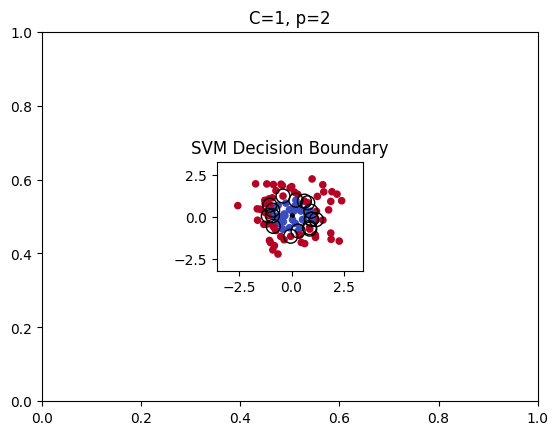

     pcost       dcost       gap    pres   dres
 0: -2.1542e+01 -1.7910e+02  8e+02  2e+00  2e-13
 1: -1.3888e+01 -9.7370e+01  1e+02  3e-01  6e-14
 2: -8.8369e+00 -4.1886e+01  5e+01  9e-02  8e-14
 3: -7.3757e+00 -2.1443e+01  2e+01  4e-02  3e-14
 4: -6.5434e+00 -1.6954e+01  2e+01  2e-02  2e-14
 5: -4.1148e+00 -9.2935e+00  1e+01  9e-03  2e-14
 6: -2.9633e+00 -4.0538e+00  2e+00  1e-03  1e-14
 7: -2.8463e+00 -3.0384e+00  3e-01  1e-04  1e-14
 8: -2.8718e+00 -2.8947e+00  3e-02  1e-05  2e-14
 9: -2.8762e+00 -2.8766e+00  5e-04  2e-07  2e-14
10: -2.8763e+00 -2.8763e+00  5e-06  2e-09  1e-14
11: -2.8763e+00 -2.8763e+00  5e-08  2e-11  1e-14
Optimal solution found.


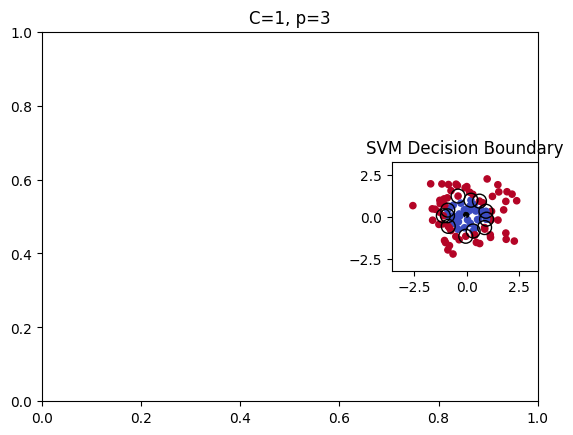

     pcost       dcost       gap    pres   dres
 0: -2.5504e+02 -9.6193e+03  3e+04  1e+00  5e-14
 1: -1.2960e+02 -4.7745e+03  8e+03  3e-01  4e-14
 2: -2.1860e+01 -1.8834e+03  3e+03  9e-02  3e-14
 3:  3.8170e+01 -5.0050e+02  7e+02  2e-02  2e-14
 4: -3.6465e-01 -9.4483e+01  1e+02  6e-04  1e-14
 5: -1.4181e+01 -8.4505e+01  7e+01  4e-04  2e-14
 6: -2.9396e+01 -6.3086e+01  3e+01  2e-04  2e-14
 7: -3.9003e+01 -5.2133e+01  1e+01  3e-05  2e-14
 8: -4.3476e+01 -4.6166e+01  3e+00  8e-07  2e-14
 9: -4.4574e+01 -4.4769e+01  2e-01  4e-08  2e-14
10: -4.4656e+01 -4.4658e+01  2e-03  4e-10  2e-14
11: -4.4657e+01 -4.4657e+01  2e-05  4e-12  2e-14
Optimal solution found.


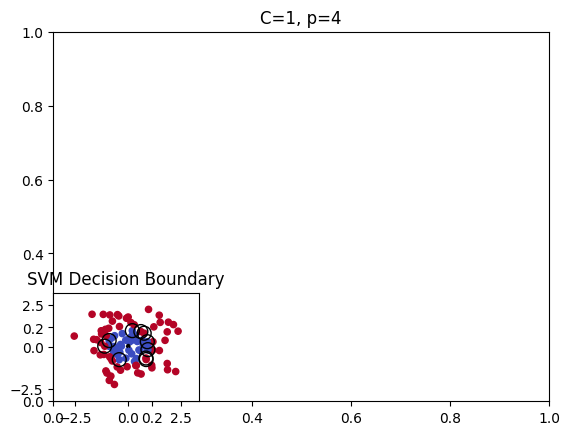

     pcost       dcost       gap    pres   dres
 0: -2.6229e+02 -9.9391e+03  3e+04  1e+00  3e-13
 1: -1.4273e+02 -5.8790e+03  1e+04  3e-01  1e-13
 2: -2.0798e+01 -1.5122e+03  3e+03  7e-02  8e-14
 3:  2.9295e+01 -3.3297e+02  5e+02  1e-02  4e-14
 4:  9.5278e+00 -3.5834e+01  5e+01  6e-05  2e-14
 5: -4.3298e+00 -1.4642e+01  1e+01  1e-05  1e-14
 6: -1.0009e+01 -1.3273e+01  3e+00  2e-06  1e-14
 7: -1.1390e+01 -1.2031e+01  6e-01  1e-07  2e-14
 8: -1.1659e+01 -1.1669e+01  9e-03  1e-09  2e-14
 9: -1.1663e+01 -1.1663e+01  9e-05  1e-11  2e-14
10: -1.1663e+01 -1.1663e+01  9e-07  1e-13  2e-14
Optimal solution found.


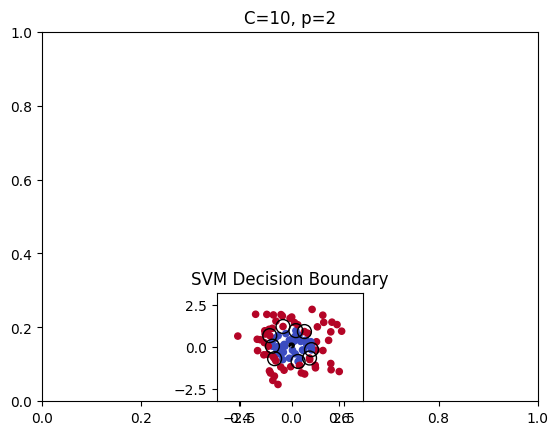

     pcost       dcost       gap    pres   dres
 0: -8.2943e+01 -5.3150e+03  1e+04  6e-01  1e-12
 1:  9.4826e+00 -1.4745e+03  3e+03  1e-01  6e-13
 2:  3.6178e+01 -2.9517e+02  5e+02  2e-02  2e-13
 3:  1.5412e+01 -2.0065e+02  3e+02  8e-03  1e-13
 4:  4.6431e+00 -7.2355e+01  1e+02  2e-03  7e-14
 5:  7.6912e-01 -6.5996e+00  8e+00  2e-05  4e-14
 6: -1.4290e+00 -3.5479e+00  2e+00  4e-06  1e-14
 7: -2.5961e+00 -3.1478e+00  6e-01  7e-07  1e-14
 8: -2.8442e+00 -2.9169e+00  7e-02  8e-08  1e-14
 9: -2.8790e+00 -2.8865e+00  7e-03  8e-09  2e-14
10: -2.8831e+00 -2.8832e+00  1e-04  9e-11  1e-14
11: -2.8832e+00 -2.8832e+00  1e-06  9e-13  2e-14
Optimal solution found.


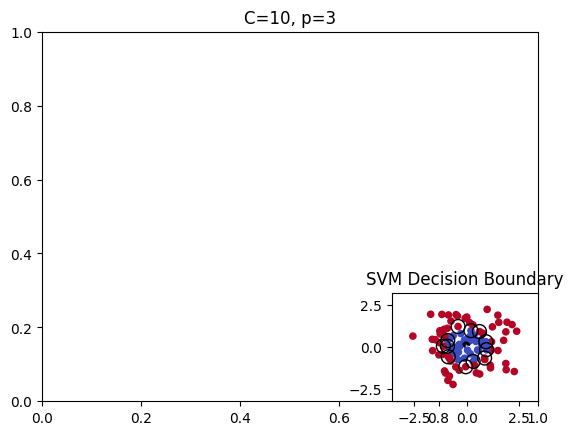

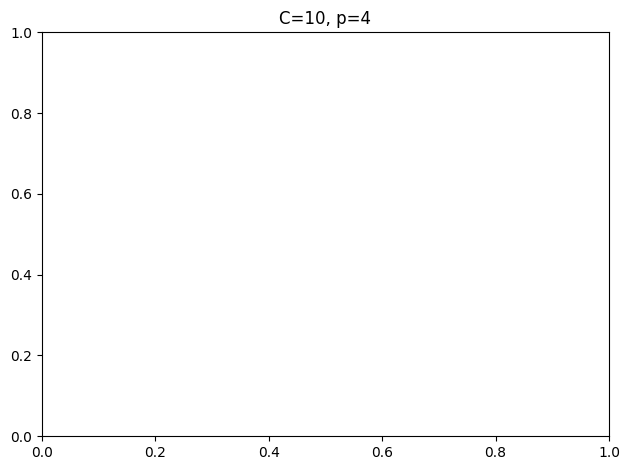

In [46]:
import matplotlib.pyplot as plt

def plot_polynomial_svm(X, y, C_values, p_values):
    plt.figure(figsize=(12, 10))
    for i, C in enumerate(C_values):
        for j, p in enumerate(p_values):
            plt.subplot(len(C_values), len(p_values), i * len(p_values) + j + 1)
            alphas, sv, sv_labels = svm_train(X, y, C, lambda x1, x2: polynomial_kernel(x1, x2, p))
            plot_decision_boundary(X, y, alphas, sv, sv_labels, lambda x1, x2: polynomial_kernel(x1, x2, p))
            plt.title(f'C={C}, p={p}')
    
    plt.tight_layout()
    plt.show()

np.random.seed(0)
X = np.random.randn(100, 2)
y = np.sign(X[:, 0]**2 + X[:, 1]**2 - 1)

C_values = [0.1, 1, 10]
p_values = [2, 3, 4]

plot_polynomial_svm(X, y, C_values, p_values)


* Увеличение степени ядра p приведет к более сложным разделяющим поверхностям, но может вызвать переобучение при слишком больших значениях

* Параметр C контролирует штраф за ошибки классификации: низкое значение приводит к более гладкой границе, а высокое — к более сложной

     pcost       dcost       gap    pres   dres
 0: -3.0433e+01 -2.2151e+01  4e+02  2e+01  9e-16
 1: -9.1908e+00 -1.9405e+01  3e+01  8e-01  1e-15
 2: -6.9566e+00 -1.0363e+01  3e+00  2e-16  7e-16
 3: -7.1241e+00 -7.9031e+00  8e-01  2e-16  3e-16
 4: -7.3142e+00 -7.4570e+00  1e-01  3e-16  4e-16
 5: -7.3665e+00 -7.3966e+00  3e-02  2e-16  4e-16
 6: -7.3793e+00 -7.3829e+00  4e-03  1e-16  4e-16
 7: -7.3807e+00 -7.3813e+00  6e-04  2e-16  4e-16
 8: -7.3810e+00 -7.3810e+00  1e-05  2e-16  4e-16
 9: -7.3810e+00 -7.3810e+00  4e-07  5e-16  4e-16
Optimal solution found.


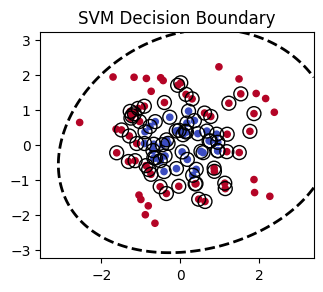

     pcost       dcost       gap    pres   dres
 0: -1.3809e+01 -1.9751e+01  4e+02  2e+01  4e-16
 1: -5.3670e+00 -1.8257e+01  2e+01  3e-01  5e-16
 2: -5.1849e+00 -6.6593e+00  1e+00  2e-16  4e-16
 3: -5.5388e+00 -5.8359e+00  3e-01  2e-16  2e-16
 4: -5.6210e+00 -5.6905e+00  7e-02  3e-16  2e-16
 5: -5.6428e+00 -5.6608e+00  2e-02  2e-16  2e-16
 6: -5.6489e+00 -5.6523e+00  3e-03  2e-16  2e-16
 7: -5.6504e+00 -5.6505e+00  1e-04  2e-16  2e-16
 8: -5.6505e+00 -5.6505e+00  4e-06  2e-16  2e-16
Optimal solution found.


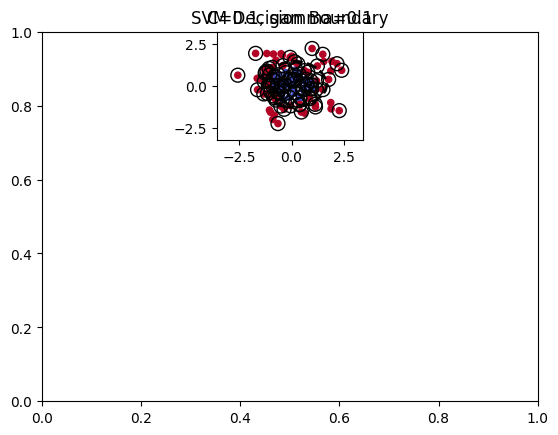

     pcost       dcost       gap    pres   dres
 0: -1.6472e+01 -2.2711e+01  4e+02  2e+01  3e-16
 1: -9.3221e+00 -1.8830e+01  3e+01  1e+00  4e-16
 2: -6.6030e+00 -1.0881e+01  4e+00  3e-16  1e-15
 3: -6.7305e+00 -7.1994e+00  5e-01  1e-16  3e-16
 4: -6.7737e+00 -6.8311e+00  6e-02  2e-16  3e-16
 5: -6.7838e+00 -6.7925e+00  9e-03  3e-16  3e-16
 6: -6.7860e+00 -6.7868e+00  8e-04  2e-16  3e-16
 7: -6.7862e+00 -6.7863e+00  2e-05  5e-16  2e-16
 8: -6.7863e+00 -6.7863e+00  4e-07  4e-16  3e-16
Optimal solution found.


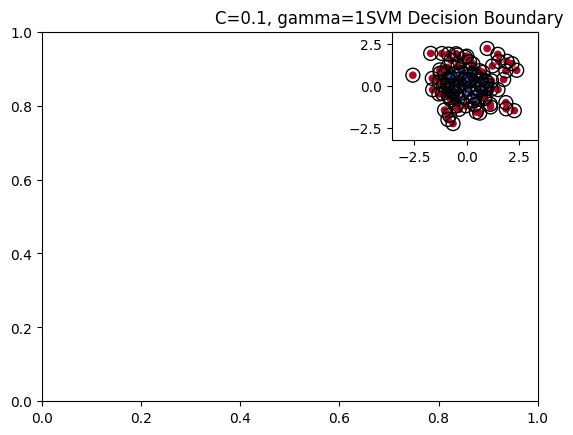

     pcost       dcost       gap    pres   dres
 0: -4.9428e+01 -2.0312e+02  6e+02  2e+00  2e-15
 1: -4.0441e+01 -1.2402e+02  8e+01  4e-15  1e-15
 2: -4.8391e+01 -6.2404e+01  1e+01  2e-16  1e-15
 3: -5.2960e+01 -5.6170e+01  3e+00  1e-15  1e-15
 4: -5.3913e+01 -5.4986e+01  1e+00  4e-15  1e-15
 5: -5.4202e+01 -5.4673e+01  5e-01  2e-15  1e-15
 6: -5.4399e+01 -5.4440e+01  4e-02  3e-15  1e-15
 7: -5.4417e+01 -5.4418e+01  8e-04  4e-15  2e-15
 8: -5.4417e+01 -5.4417e+01  8e-06  9e-16  2e-15
Optimal solution found.


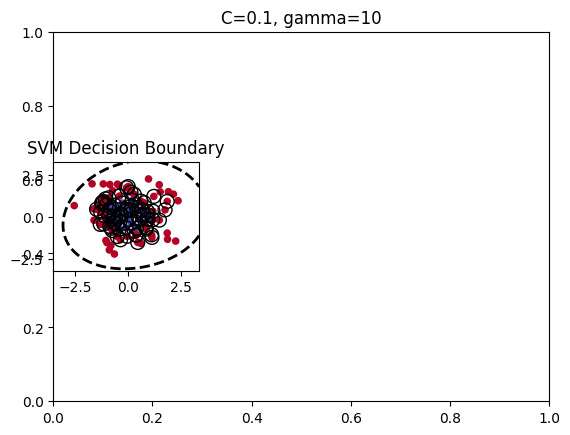

     pcost       dcost       gap    pres   dres
 0: -2.0033e+01 -1.6157e+02  5e+02  2e+00  6e-16
 1: -1.4102e+01 -8.2417e+01  7e+01  7e-16  5e-16
 2: -1.9468e+01 -3.3721e+01  1e+01  4e-16  6e-16
 3: -2.2727e+01 -2.6604e+01  4e+00  2e-15  5e-16
 4: -2.3905e+01 -2.4610e+01  7e-01  7e-16  5e-16
 5: -2.4139e+01 -2.4238e+01  1e-01  1e-15  4e-16
 6: -2.4176e+01 -2.4189e+01  1e-02  9e-16  5e-16
 7: -2.4181e+01 -2.4181e+01  2e-04  4e-16  5e-16
 8: -2.4181e+01 -2.4181e+01  2e-06  3e-15  5e-16
Optimal solution found.


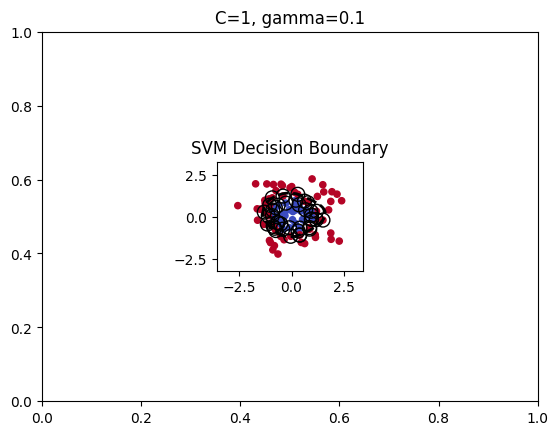

     pcost       dcost       gap    pres   dres
 0: -2.0228e+01 -1.5209e+02  1e+02  3e-15  5e-16
 1: -2.1236e+01 -3.3355e+01  1e+01  2e-15  3e-16
 2: -2.2360e+01 -2.4411e+01  2e+00  2e-16  2e-16
 3: -2.2679e+01 -2.2985e+01  3e-01  5e-16  2e-16
 4: -2.2741e+01 -2.2771e+01  3e-02  9e-16  2e-16
 5: -2.2748e+01 -2.2752e+01  4e-03  1e-15  2e-16
 6: -2.2749e+01 -2.2749e+01  3e-04  7e-16  2e-16
 7: -2.2749e+01 -2.2749e+01  3e-06  9e-16  1e-16
Optimal solution found.


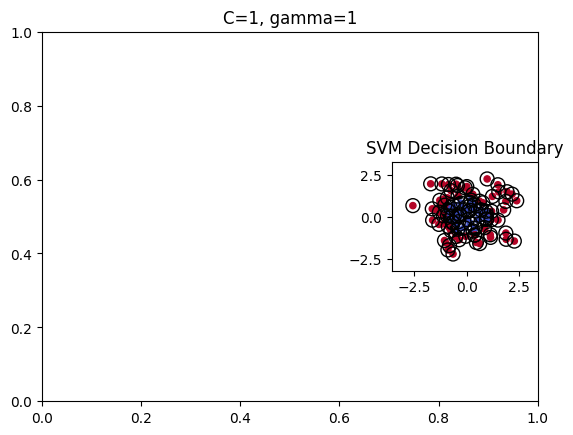

     pcost       dcost       gap    pres   dres
 0:  5.2893e+01 -6.3469e+03  1e+04  4e-01  9e-15
 1:  1.4680e+01 -8.1513e+02  8e+02  1e-03  7e-15
 2: -1.5360e+02 -3.4291e+02  2e+02  2e-04  8e-15
 3: -2.1637e+02 -3.0231e+02  9e+01  7e-05  7e-15
 4: -2.4180e+02 -2.8144e+02  4e+01  3e-05  9e-15
 5: -2.5362e+02 -2.6833e+02  1e+01  6e-06  9e-15
 6: -2.5829e+02 -2.6355e+02  5e+00  1e-06  1e-14
 7: -2.6053e+02 -2.6081e+02  3e-01  4e-08  1e-14
 8: -2.6066e+02 -2.6066e+02  6e-03  8e-10  1e-14
 9: -2.6066e+02 -2.6066e+02  1e-04  1e-11  1e-14
Optimal solution found.


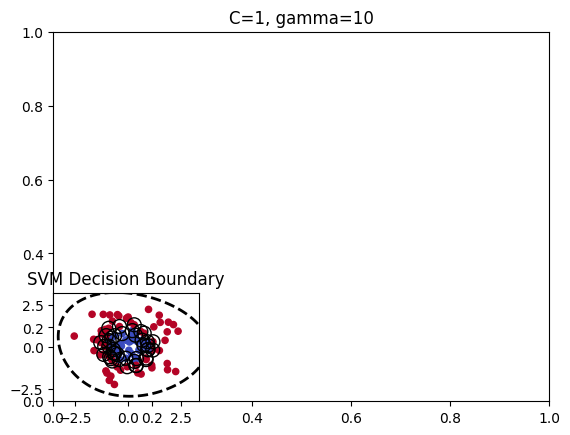

     pcost       dcost       gap    pres   dres
 0:  1.6887e+02 -4.1072e+03  7e+03  3e-01  4e-15
 1:  1.2853e+02 -5.4462e+02  7e+02  1e-02  3e-15
 2: -1.2640e+01 -1.0825e+02  1e+02  7e-04  2e-15
 3: -4.6324e+01 -8.4003e+01  4e+01  2e-04  2e-15
 4: -5.7865e+01 -7.6946e+01  2e+01  2e-05  2e-15
 5: -6.4363e+01 -6.7932e+01  4e+00  3e-06  2e-15
 6: -6.5525e+01 -6.6291e+01  8e-01  4e-07  3e-15
 7: -6.5797e+01 -6.5917e+01  1e-01  6e-08  3e-15
 8: -6.5848e+01 -6.5850e+01  2e-03  5e-10  3e-15
 9: -6.5849e+01 -6.5849e+01  2e-05  5e-12  2e-15
Optimal solution found.


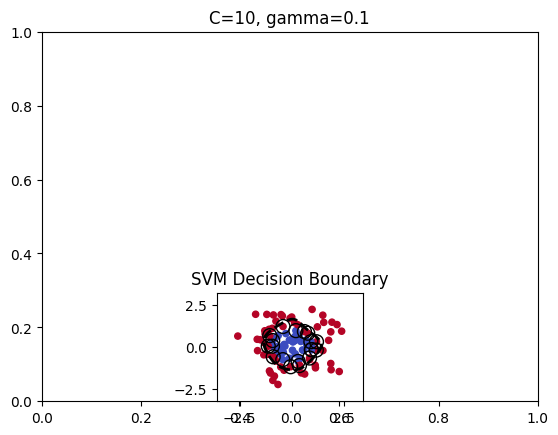

     pcost       dcost       gap    pres   dres
 0:  4.2335e+02 -3.2865e+03  4e+03  1e-14  3e-15
 1:  7.9349e+01 -3.6064e+02  4e+02  8e-15  2e-15
 2: -1.4542e+01 -6.0271e+01  5e+01  2e-15  9e-16
 3: -2.3212e+01 -2.9290e+01  6e+00  1e-15  3e-16
 4: -2.4125e+01 -2.5197e+01  1e+00  5e-16  2e-16
 5: -2.4377e+01 -2.4530e+01  2e-01  7e-16  2e-16
 6: -2.4419e+01 -2.4427e+01  7e-03  1e-15  2e-16
 7: -2.4422e+01 -2.4423e+01  2e-04  2e-15  2e-16
 8: -2.4422e+01 -2.4422e+01  3e-06  1e-15  2e-16
Optimal solution found.


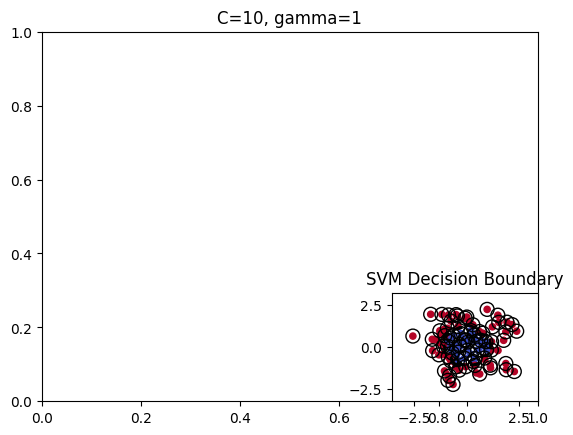

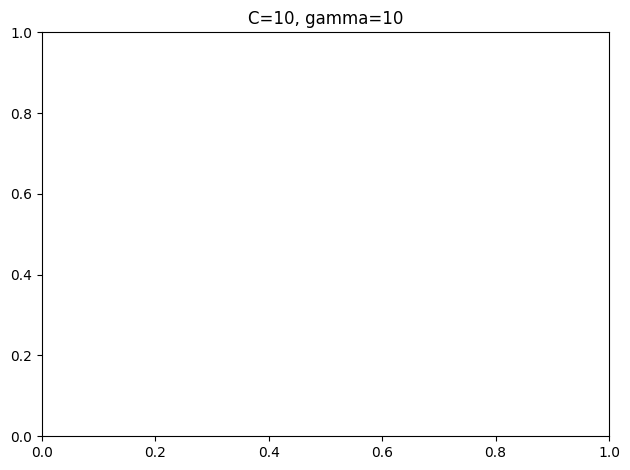

In [47]:
def plot_rbf_svm(X, y, C_values, gamma_values):
    plt.figure(figsize=(12, 10))
    for i, C in enumerate(C_values):
        for j, gamma in enumerate(gamma_values):
            plt.subplot(len(C_values), len(gamma_values), i * len(gamma_values) + j + 1)
            alphas, sv, sv_labels = svm_train(X, y, C, lambda x1, x2: rbf_kernel(x1, x2, gamma))
            plot_decision_boundary(X, y, alphas, sv, sv_labels, lambda x1, x2: rbf_kernel(x1, x2, gamma))
            plt.title(f'C={C}, gamma={gamma}')
    
    plt.tight_layout()
    plt.show()

C_values = [0.1, 1, 10]
gamma_values = [0.1, 1, 10]

plot_rbf_svm(X, y, C_values, gamma_values)


* Параметр γ определяет ширину гауссовского ядра: маленькое значение делает модель более гладкой, а большое — более сложной

* Параметр C аналогично влияет на гибкость модели

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [49]:
%matplotlib inline

## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

/var/folders/vt/1_33k3fx71sdxz3q5nb3qhtw0000gn/T/ipykernel_46304/2390794766.py:16: UserWarning: linewidths is ignored by contourf
  contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')


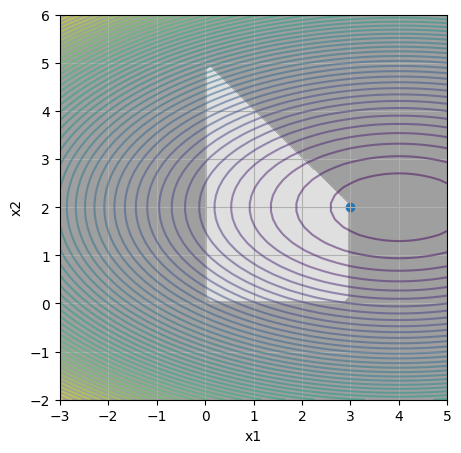

In [50]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [51]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [52]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [53]:
!pip install --upgrade --user cvxopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 5.9 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [54]:
from cvxopt import solvers
?solvers.qp

Signature:
solvers.qp(
    P,
    q,
    G=None,
    h=None,
    A=None,
    b=None,
    solver=None,
    kktsolver=None,
    initvals=None,
    **kwargs,
)
Docstring:
Solves a quadratic program

    minimize    (1/2)*x'*P*x + q'*x
    subject to  G*x <= h
                A*x = b.


Input arguments.

    P is a n x n dense or sparse 'd' matrix with the lower triangular
    part of P stored in the lower triangle.  Must be positive
    semidefinite.

    q is an n x 1 dense 'd' matrix.

    G is an m x n dense or sparse 'd' matrix.

    h is an m x 1 dense 'd' matrix.

    A is a p x n dense or sparse 'd' matrix.

    b is a p x 1 dense 'd' matrix or None.

    solver is None or 'mosek'.

    The default values for G, h, A and b are empty matrices with
    zero rows.


Output arguments (default solver).

    Returns a dictionary with keys 'status', 'x', 's', 'y', 'z',
    'primal objective', 'dual objective', 'gap', 'relative gap',
    'primal infeasibility, 'dual infeasibility', 'primal

## Пример работы с cvxopt

In [55]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [56]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [57]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  6e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  2e-16  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  2e-16  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  6e-17  3e-16
 6:  2.0062e+01  1.9974e+01  9e-02  9e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  1e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  3e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [58]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731700882e-06,
 'relative gap': 4.394277440499181e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.4066544268421197e-16,
 'dual infeasibility': 2.9763180929248306e-16,
 'primal slack': 7.131816408856409e-07,
 'dual slack': 1.5069511036047206e-08,
 'iterations': 8}

In [59]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [60]:
from sklearn.datasets import make_classification

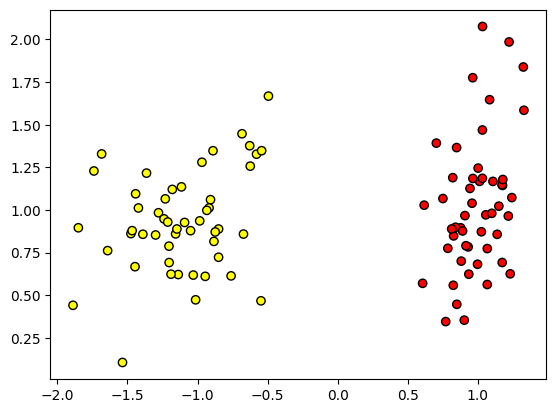

In [61]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

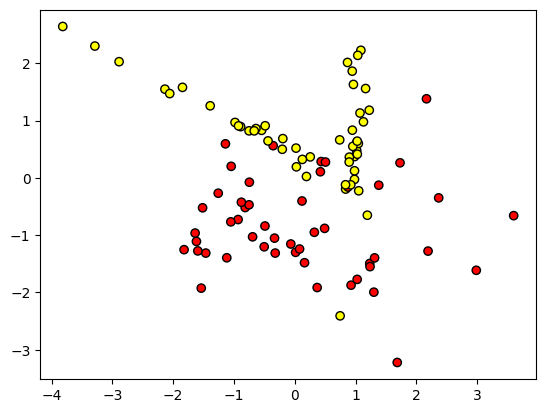

In [62]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

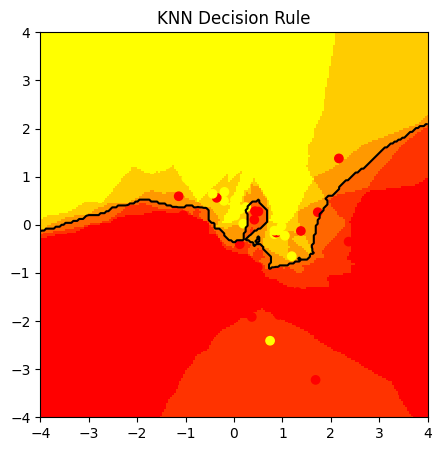

In [63]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [71]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [72]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass